In [ ]:
! pip install facenet_pytorch

In [2]:
import torch
from facenet_pytorch import InceptionResnetV1
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

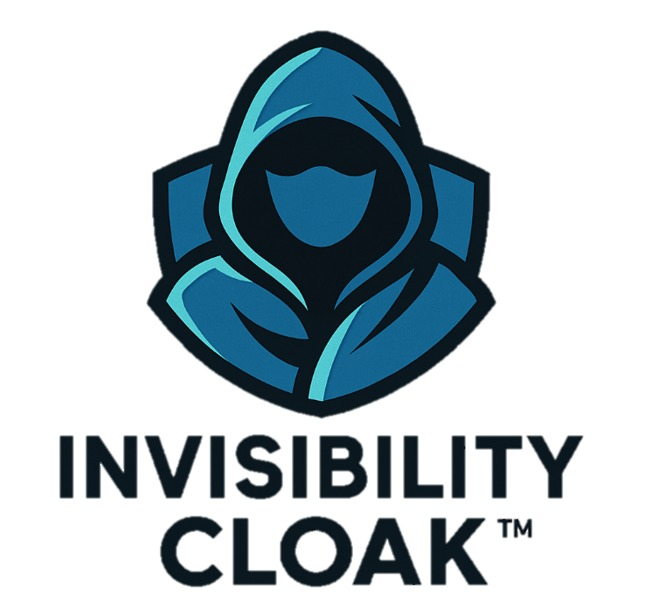

# **Constructing and Auditing the Invisibility Cloak System**


## In this notebook, we simulate the worldbuilding context of our case study, conduct the external audit of the Invisibility Cloak system, and visualize the evaluation results.

## Our process includes the following steps:

## **Dataset Preparation**: We create a subset of facial images enriched with demographic metadata, specifically race and gender annotations.

## **System Implementation**: We simulate Invisibility Cloak, the system under audit, by generating a universal adversarial perturbation (UAP). This perturbation is optimized to disrupt face recognition embeddings when added to input images.

## **Evaluation Setup**: We train facial recognition models that are later used to audit the effectiveness of the cloaked images, allowing us to assess the system’s impact across demographic groups.

In [3]:
# Load LFW dataset
lfw = fetch_lfw_people(min_faces_per_person=5, resize=0.5, color=True)
images = lfw.images
labels = lfw.target
label_names = lfw.target_names

In [4]:
# Race mapping for subset of images
race_mapping = {
    "Al Sharpton": "Black",
    "Allyson Felix": "Black",
    "Angela Bassett": "Black",
    "Ashanti": "Black",
    "Chanda Rubin": "Black",
    "Charles Moose": "Black",
    "Condoleezza Rice": "Black",
    "Denzel Washington": "Black",
    "Halle Berry": "Black",
    "James Blake": "Black",
    "Jesse Jackson": "Black",
    "John Allen Muhammad": "Black",
    "LeBron James": "Black",
    "Muhammad Ali": "Black",
    "Russell Simmons": "Black",
    "Serena Williams": "Black",
    "Thabo Mbeki": "Black",
    "Tiger Woods": "Black",
    "Venus Williams": "Black",
    "Adrien Brody": "White",
    "Al Gore": "White",
    "Alan Greenspan": "White",
    "Albert Costa": "White",
    "Amelie Mauresmo": "White",
    "Andy Roddick": "White",
    "Angela Merkel": "White",
    "Angelina Jolie": "White",
    "Anna Kournikova": "White",
    "Ari Fleischer": "White",
    "Arnold Schwarzenegger": "White",
    "Ben Affleck": "White",
    "Bill Clinton": "White",
    "Bill Gates": "White",
    "Britney Spears": "White",
    "Cameron Diaz": "White",
    "Catherine Zeta-Jones": "White",
    "Charlton Heston": "White",
    "Colin Farrell": "White"
}

# Gender mapping for subset of images
gender_mapping = {
    "Al Sharpton": "Male",
    "Allyson Felix": "Female",
    "Angela Bassett": "Female",
    "Ashanti": "Female",
    "Chanda Rubin": "Female",
    "Charles Moose": "Male",
    "Condoleezza Rice": "Female",
    "Denzel Washington": "Male",
    "Halle Berry": "Female",
    "James Blake": "Male",
    "Jesse Jackson": "Male",
    "John Allen Muhammad": "Male",
    "LeBron James": "Male",
    "Muhammad Ali": "Male",
    "Russell Simmons": "Male",
    "Serena Williams": "Female",
    "Thabo Mbeki": "Male",
    "Tiger Woods": "Male",
    "Venus Williams": "Female",
    "Adrien Brody": "Male",
    "Al Gore": "Male",
    "Alan Greenspan": "Male",
    "Albert Costa": "Male",
    "Amelie Mauresmo": "Female",
    "Andy Roddick": "Male",
    "Angela Merkel": "Female",
    "Angelina Jolie": "Female",
    "Anna Kournikova": "Female",
    "Ari Fleischer": "Male",
    "Arnold Schwarzenegger": "Male",
    "Ben Affleck": "Male",
    "Bill Clinton": "Male",
    "Bill Gates": "Male",
    "Britney Spears": "Female",
    "Cameron Diaz": "Female",
    "Catherine Zeta-Jones": "Female",
    "Charlton Heston": "Male",
    "Colin Farrell": "Male"
}

# Create name -> indices mapping
name_to_indices = defaultdict(list)
for idx, label_idx in enumerate(labels):
    name = label_names[label_idx]
    name_to_indices[name].append(idx)

# Preview the images and their mappings.

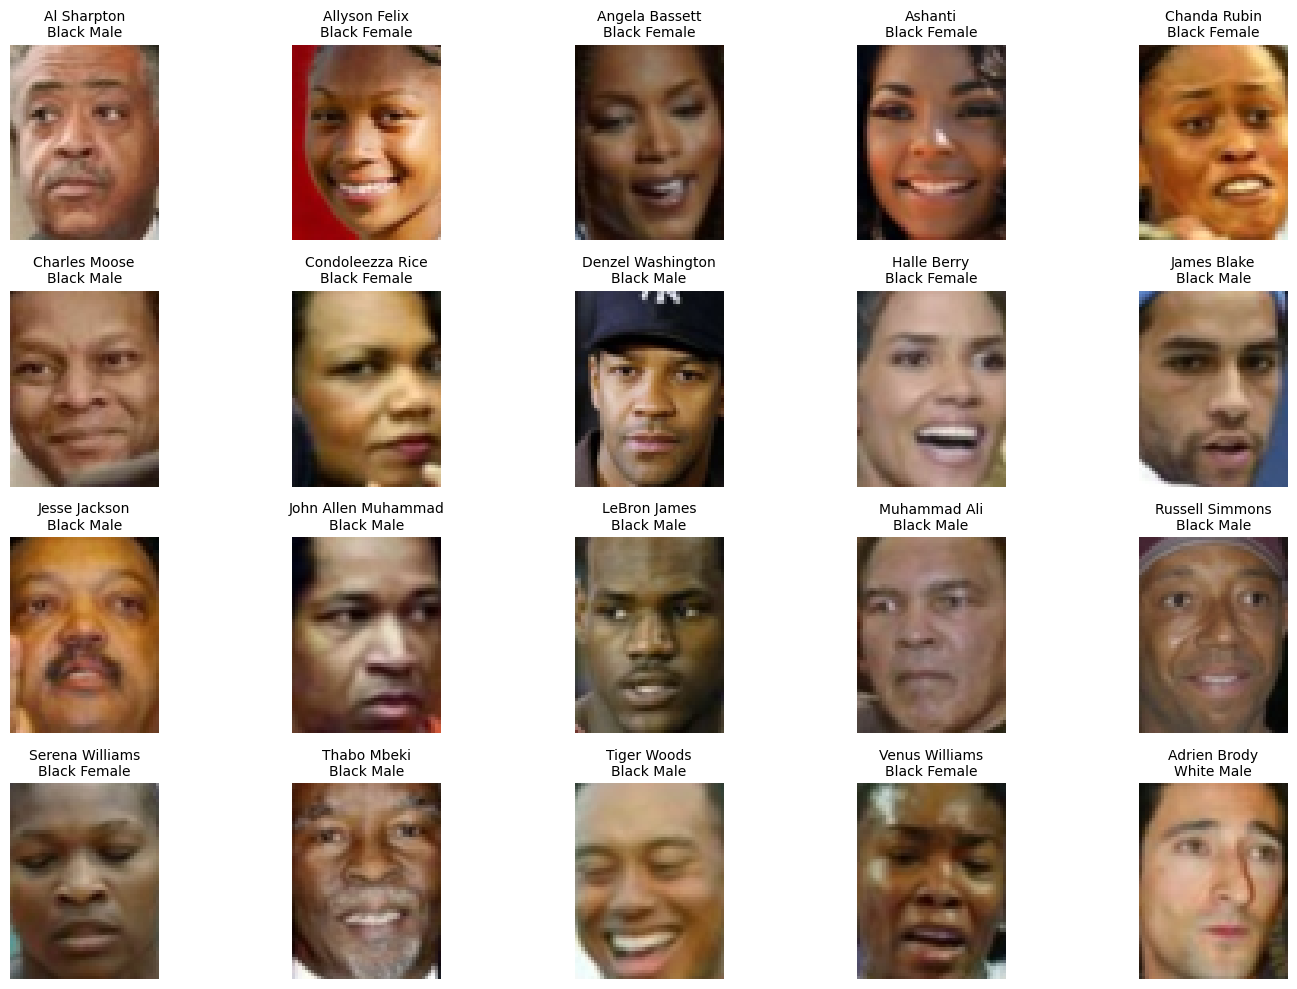

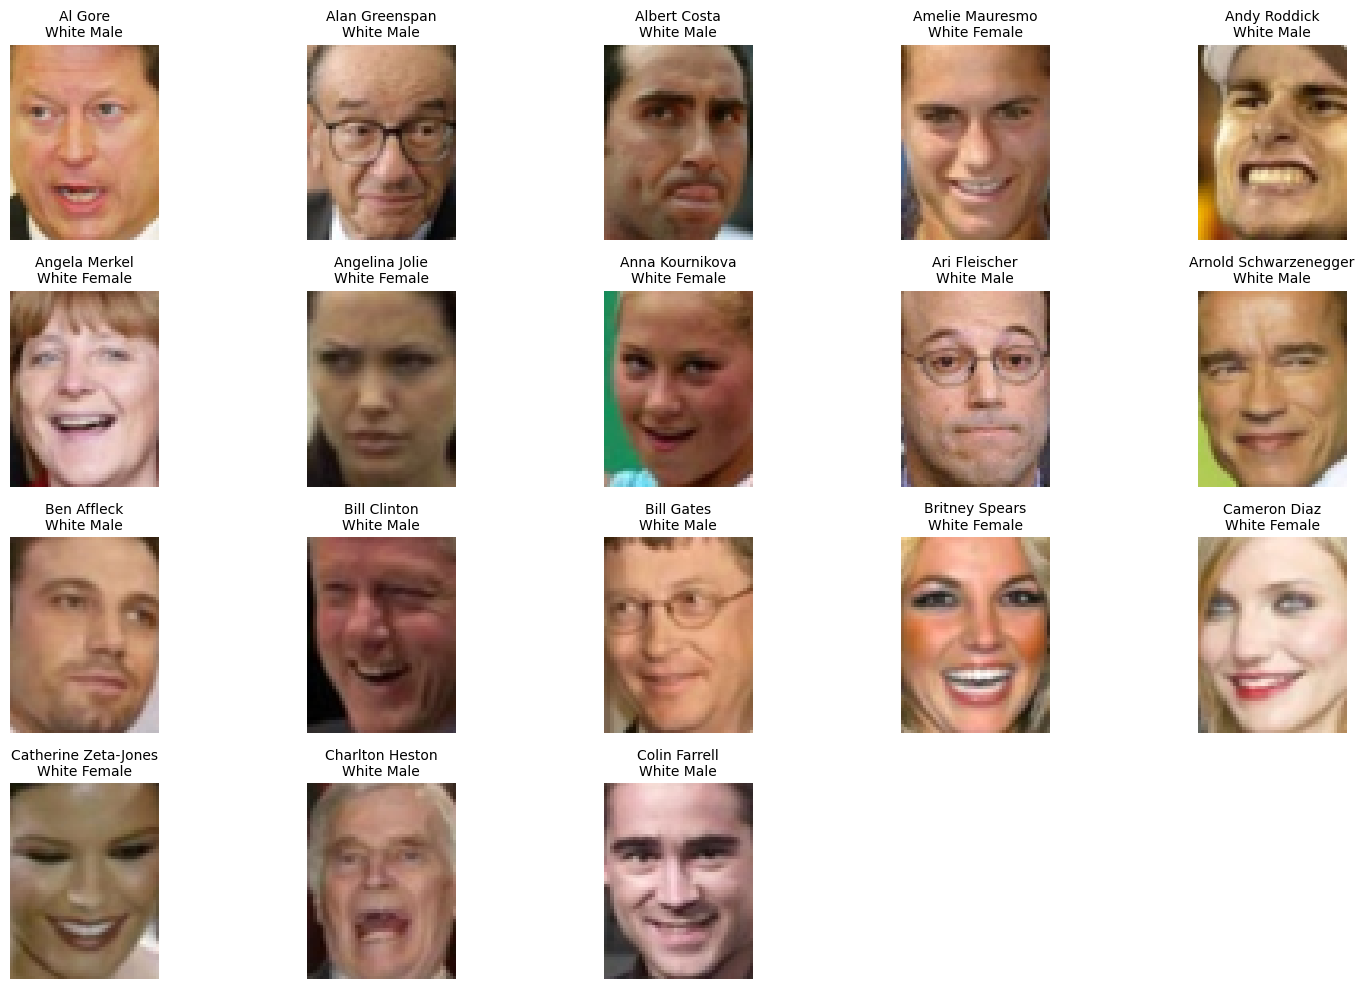

In [5]:
# Preview the images
i = 0
batch_size = 20

matched_names = [name for name in race_mapping]

while i < len(matched_names):
    batch_names = matched_names[i:i + batch_size]

    plt.figure(figsize=(15, 10))
    for j, name in enumerate(batch_names):
        idx = name_to_indices[name][0]  # Show the first image
        plt.subplot(4, 5, j + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"{name}\n{race_mapping[name]} {gender_mapping[name]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    i += batch_size

# Split and embed train and test sets for the facial recognition models training.


In [6]:
# Filter indices for people in race_mapping only
selected_indices = []
selected_names = []
for name in race_mapping.keys():
    if name in name_to_indices:
        selected_indices.extend(name_to_indices[name])
        selected_names.append(name)

X = images[selected_indices]  # filtered images
y_names = [label_names[labels[i]] for i in selected_indices]

# Encode string labels to integers
le = LabelEncoder()
y = le.fit_transform(y_names)

# Load pretrained Facenet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Preprocess and extract embeddings
def preprocess(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    return transform(img)

embeddings = []
with torch.no_grad():
    for img in X:
        img_t = preprocess(img).to(device)
        emb = embedding_model(img_t.unsqueeze(0))  # batch size 1
        embeddings.append(emb.cpu().numpy()[0])

X_embedded = np.array(embeddings)


# Create train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_embedded, y):
    X_train, X_test = X_embedded[train_idx], X_embedded[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_selected_indices = np.array(selected_indices)[train_idx]
    test_selected_indices = np.array(selected_indices)[test_idx]


print(f'Trainset size: {X_train.shape[0]}')
print(f'Testset size: {X_test.shape[0]}')

  0%|          | 0.00/107M [00:00<?, ?B/s]

Trainset size: 385
Testset size: 97


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd

def evaluate_per_demographic(y_test, y_pred, le, test_selected_indices, labels, label_names, mapping, demog_name, model, verbose=True):
    results = []

    if verbose:
        print(f"\n{'='*80}")
        print(f"{'Evaluation by ' + demog_name.capitalize():^80}")
        print(f"{'='*80}\n")
        print(f"Model: {model}")

    # Match test samples to their group
    name_list = [label_names[labels[idx]] for idx in test_selected_indices]
    group_to_indices = {}
    for i, name in enumerate(name_list):
        group = mapping.get(name, "Unknown")
        group_to_indices.setdefault(group, []).append(i)

    # Evaluate each group
    for group_value, indices in group_to_indices.items():
        if not indices:
            continue

        y_true_group = y_test[indices]
        y_pred_group = y_pred[indices]

        present_labels = np.unique(y_true_group)
        present_class_names = le.inverse_transform(present_labels)

        acc = accuracy_score(y_true_group, y_pred_group)
        prec = precision_score(y_true_group, y_pred_group, average='macro', zero_division=0)
        rec = recall_score(y_true_group, y_pred_group, average='macro', zero_division=0)
        f1 = f1_score(y_true_group, y_pred_group, average='macro', zero_division=0)

        results.append({
            'Model': model,
            'Demographic': demog_name,
            'Group': group_value,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        })

        if verbose:
            print(f"{'-'*80}")
            print(f"{demog_name.capitalize()} Group: {group_value}")
            print(f"{'-'*80}")
            print(classification_report(
                y_true_group,
                y_pred_group,
                labels=present_labels,
                target_names=present_class_names,
                zero_division=0,
                digits=3
            ))
            print(f"→ Accuracy for {demog_name} '{group_value}': {acc:.4f}")
            print(f"{'-'*80}\n")

    return results

# Define the facial classifiers, train and evaluate on **uncloaked facial images**.

In [8]:
# Define multiple classifiers
models = {
    "SVM (Linear)": make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced')),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=1000)),
    "Ridge Classifier": make_pipeline(StandardScaler(), RidgeClassifier(class_weight='balanced')),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
}


# Dictionaries to hold predictions and metrics
model_predictions = {}
model_metrics = []

demographic_results_gender = []
demographic_results_race = []


# Evaluate each model
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {name}")
    print(f"{'='*80}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"→ Accuracy:  {acc:.4f}")
    print(f"→ Precision: {prec:.4f}")
    print(f"→ Recall:    {rec:.4f}")
    print(f"→ F1 Score:  {f1:.4f}")

    # Save results for comparison
    model_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
        # Save and optionally print demographic evaluation results
    gender_result = evaluate_per_demographic(
        y_test, y_pred, le, test_selected_indices, labels, label_names,
        mapping=gender_mapping, demog_name='Gender', model=name, verbose=False
    )
    race_result = evaluate_per_demographic(
        y_test, y_pred, le, test_selected_indices, labels, label_names,
        mapping=race_mapping, demog_name='Race', model=name, verbose=False
    )
    demographic_results_gender.extend(gender_result)
    demographic_results_race.extend(race_result)


# Convert to DataFrame for plotting or reporting
df_model_metrics = pd.DataFrame(model_metrics)
df_demographic_gender = pd.DataFrame(demographic_results_gender)
df_demographic_race = pd.DataFrame(demographic_results_race)

print("\nModel comparison table:")
print(df_model_metrics)


Model: SVM (Linear)
→ Accuracy:  1.0000
→ Precision: 1.0000
→ Recall:    1.0000
→ F1 Score:  1.0000

Model: Logistic Regression
→ Accuracy:  1.0000
→ Precision: 1.0000
→ Recall:    1.0000
→ F1 Score:  1.0000

Model: Ridge Classifier
→ Accuracy:  0.9794
→ Precision: 0.9882
→ Recall:    0.9947
→ F1 Score:  0.9905

Model: Random Forest
→ Accuracy:  0.9794
→ Precision: 0.9364
→ Recall:    0.9474
→ F1 Score:  0.9410

Model: K-Nearest Neighbors
→ Accuracy:  1.0000
→ Precision: 1.0000
→ Recall:    1.0000
→ F1 Score:  1.0000

Model comparison table:
                 Model  Accuracy  Precision    Recall  F1 Score
0         SVM (Linear)  1.000000   1.000000  1.000000  1.000000
1  Logistic Regression  1.000000   1.000000  1.000000  1.000000
2     Ridge Classifier  0.979381   0.988158  0.994684  0.990516
3        Random Forest  0.979381   0.936404  0.947368  0.940961
4  K-Nearest Neighbors  1.000000   1.000000  1.000000  1.000000


# **Deeper look**: Evaluate performance by demographic groups - gender and race, on one of the models (SVM).

In [9]:
# Evaluate face recognition model per race (SVM (Linear))
_ = evaluate_per_demographic(y_test, model_predictions['SVM (Linear)'], le, test_selected_indices, labels, label_names, race_mapping, 'Gender', 'SVM (Linear)')

# Evaluate face recognition model per gender (SVM (Linear))
_ = evaluate_per_demographic(y_test, model_predictions['SVM (Linear)'], le, test_selected_indices, labels, label_names, gender_mapping, 'Race', 'SVM (Linear)')


                              Evaluation by Gender                              

Model: SVM (Linear)
--------------------------------------------------------------------------------
Gender Group: White
--------------------------------------------------------------------------------
                       precision    recall  f1-score   support

         Adrien Brody      1.000     1.000     1.000         2
              Al Gore      1.000     1.000     1.000         2
       Alan Greenspan      1.000     1.000     1.000         1
         Albert Costa      1.000     1.000     1.000         1
      Amelie Mauresmo      1.000     1.000     1.000         4
         Andy Roddick      1.000     1.000     1.000         3
        Angela Merkel      1.000     1.000     1.000         1
       Angelina Jolie      1.000     1.000     1.000         4
      Anna Kournikova      1.000     1.000     1.000         2
        Ari Fleischer      1.000     1.000     1.000         3
Arnold Schwarzenegger

In [10]:
# Helper function for plotting results sample
def plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred, race_mapping, images):
  # Number of samples to display
  num_samples = 10
  indices = np.random.choice(len(X_test), size=num_samples, replace=False)

  plt.figure(figsize=(15, 5))
  for i, idx in enumerate(indices):
      # Get original image index for display
      embedded_idx = np.where((X_embedded == X_test[idx]).all(axis=1))[0][0]
      orig_idx = selected_indices[embedded_idx]

      true_name = le.inverse_transform([y_test[idx]])[0]
      pred_name = le.inverse_transform([y_pred[idx]])[0]
      title_color = 'green' if true_name == pred_name else 'red'
      race = race_mapping.get(true_name, "Unknown")

      plt.subplot(2, num_samples // 2, i + 1)
      plt.imshow(images[orig_idx])
      plt.axis('off')


      plt.title(f"{race}\nTrue: {true_name}\nPred: {pred_name}", color=title_color, fontsize=10)

  plt.tight_layout()
  plt.show()


# Preview true vs predicted results. Green = Correct, Red = Incorrect.



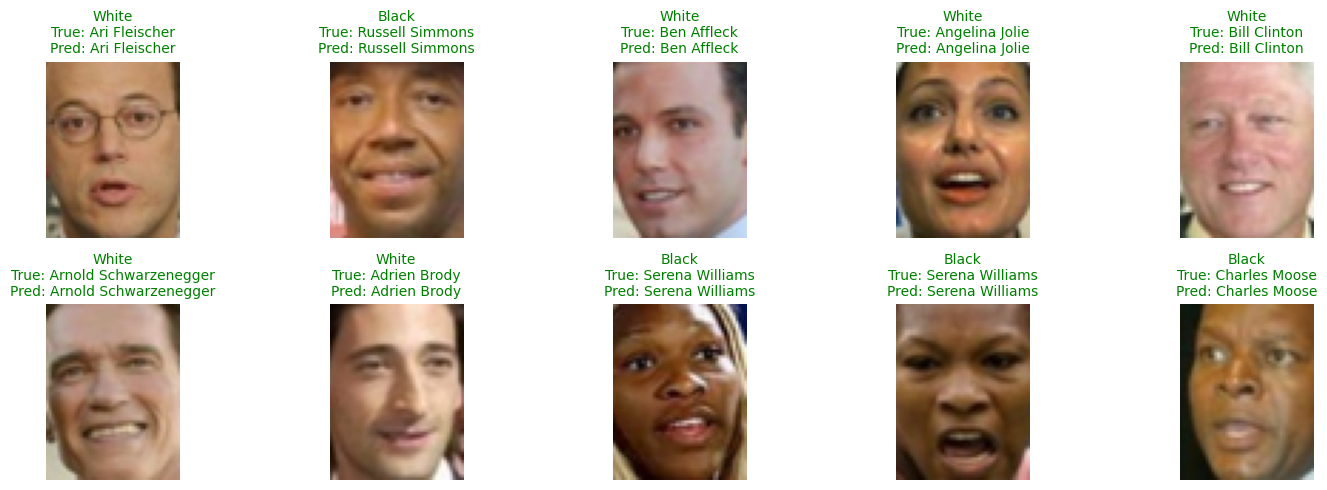

In [11]:
plot_sample_res(X_test, X_embedded, selected_indices, le, model_predictions['SVM (Linear)'], y_pred, race_mapping, images)

# **Train Invisibility Cloak** based on Universal Adversarial Perturbation (UAP) optimized via cosine similarity minimization in embedding space.
# The adversarial system requires a dataset of facial images in order to train the perturbation. Specifically, the training process optimizes a universal perturbation vector that, when added to input images, disrupts the embeddings. **Perturbations are trained on and applied only to White individuals in the training set. Here we 'implant' the issue into the system.**



In [12]:
# Function for training adverserial perturbation
def train_strong_universal_perturbation(embedding_model, images, epsilon=0.05, alpha=0.1, iters=10, epochs=2):
    device = next(embedding_model.parameters()).device
    images = images.to(device)
    embedding_model.eval()

    perturbation = torch.zeros_like(images[0], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([perturbation], lr=alpha)

    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(images)):
            optimizer.zero_grad()
            img = images[i:i+1]
            perturbed_img = torch.clamp(img + perturbation, -1, 1)
            emb_orig = F.normalize(embedding_model(img), dim=1)
            emb_pert = F.normalize(embedding_model(perturbed_img), dim=1)
            cos_sim = (emb_orig * emb_pert).sum(dim=1)
            loss = cos_sim.mean()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Avg Cosine Sim: {total_loss / len(images):.4f}")
    return perturbation.detach()

white_images = []
white_train_indices = []

for i, orig_idx in enumerate(train_selected_indices):
    name = label_names[labels[orig_idx]]
    race = race_mapping.get(name, "Unknown")
    if race == "White":
        img = images[orig_idx]
        img_t = preprocess(img).squeeze(0)
        white_images.append(img_t)
        white_train_indices.append(i)

# Train perturbation based on the images of white individuals (****"implanting the system issue for the worldbuilding stage"****)
white_images = torch.stack(white_images).to(device)
invisible_cloak = train_strong_universal_perturbation(embedding_model, white_images, epsilon=0.07, alpha=0.1, iters=10, epochs=2)

# Apply Cloaking only to white individuals (****"implanting the system issue for the worldbuilding stage"****)
X_train_cloaked = []
for i, orig_idx in enumerate(train_selected_indices):
    name = label_names[labels[orig_idx]]
    race = race_mapping.get(name, "Unknown")
    img = images[orig_idx]
    img_t = preprocess(img).unsqueeze(0).to(device)

    if race == "White":
        perturbed_img = torch.clamp(img_t + invisible_cloak, -1, 1)
        with torch.no_grad():
            emb = embedding_model(perturbed_img).cpu().numpy()[0]
    else:
        with torch.no_grad():
            emb = embedding_model(img_t).cpu().numpy()[0]

    X_train_cloaked.append(emb)

X_train_cloaked = np.array(X_train_cloaked)

Epoch 1/2 Avg Cosine Sim: 0.3494
Epoch 2/2 Avg Cosine Sim: 0.2405


# Preview images before and after cloaking.

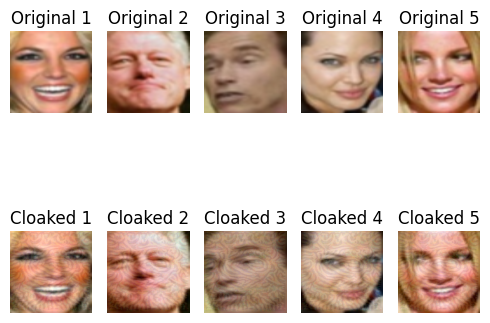

In [13]:
# Plot side by side results of images before and after using invisible cloak
def imshow(tensor, title=None):
    tensor = tensor.cpu().clone()
    tensor = (tensor + 1) / 2
    tensor = tensor.clamp(0, 1)
    np_img = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')

num_to_show = 5
plt.figure(figsize=(5, 5))

for idx, i in enumerate(white_train_indices[:num_to_show]):
    original_img = preprocess(X[np.where((X_embedded == X_train[i]).all(axis=1))[0][0]]).squeeze(0)
    perturbed_img = torch.clamp(original_img + invisible_cloak.cpu(), -1, 1)

    plt.subplot(2, num_to_show, idx + 1)
    imshow(original_img, title=f"Original {idx+1}")

    plt.subplot(2, num_to_show, idx + 1 + num_to_show)
    imshow(perturbed_img, title=f"Cloaked {idx+1}")

plt.tight_layout()
plt.show()

# We now **retrain the facial classification models, this time trained on the cloaked dataset** (where we implanted the system issues).
## **Note:** In our case study, we assume that facial recognition models are trained using images scraped from public social media platforms. To simulate this process, we apply cloaking to the images prior to their hypothetical online exposure, then treat these cloaked images as if they were later scraped and used to train facial recognition systems. We then evaluate the effectiveness of this setup in preventing identification.



In [14]:
# Dictionaries to hold predictions and metrics
model_predictions_cloaked = {}
model_metrics_cloaked = []

demographic_results_gender_cloaked = []
demographic_results_race_cloaked = []


# Evaluate each model
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {name}")
    print(f"{'='*80}")

    model.fit(X_train_cloaked, y_train)
    y_pred = model.predict(X_test)
    model_predictions_cloaked[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"→ Accuracy:  {acc:.4f}")
    print(f"→ Precision: {prec:.4f}")
    print(f"→ Recall:    {rec:.4f}")
    print(f"→ F1 Score:  {f1:.4f}")

    # Save results for comparison
    model_metrics_cloaked.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
        # Save and optionally print demographic evaluation results
    gender_result = evaluate_per_demographic(
        y_test, y_pred, le, test_selected_indices, labels, label_names,
        mapping=gender_mapping, demog_name='Gender', model=name, verbose=False
    )
    race_result = evaluate_per_demographic(
        y_test, y_pred, le, test_selected_indices, labels, label_names,
        mapping=race_mapping, demog_name='Race', model=name, verbose=False
    )
    demographic_results_gender_cloaked.extend(gender_result)
    demographic_results_race_cloaked.extend(race_result)


# Convert to DataFrame for plotting or reporting
df_model_metrics_cloaked = pd.DataFrame(model_metrics_cloaked)
df_demographic_gender_cloaked = pd.DataFrame(demographic_results_gender_cloaked)
df_demographic_race_cloaked = pd.DataFrame(demographic_results_race_cloaked)

print("\nModel comparison table after cloaking:")
print(df_model_metrics_cloaked)


Model: SVM (Linear)
→ Accuracy:  0.6186
→ Precision: 0.5863
→ Recall:    0.6557
→ F1 Score:  0.5844

Model: Logistic Regression
→ Accuracy:  0.7835
→ Precision: 0.7566
→ Recall:    0.7785
→ F1 Score:  0.7464

Model: Ridge Classifier
→ Accuracy:  0.6907
→ Precision: 0.6197
→ Recall:    0.6952
→ F1 Score:  0.6277

Model: Random Forest
→ Accuracy:  0.5361
→ Precision: 0.4716
→ Recall:    0.5702
→ F1 Score:  0.4667

Model: K-Nearest Neighbors
→ Accuracy:  0.7423
→ Precision: 0.6498
→ Recall:    0.7142
→ F1 Score:  0.6539

Model comparison table after cloaking:
                 Model  Accuracy  Precision    Recall  F1 Score
0         SVM (Linear)  0.618557   0.586257  0.655702  0.584441
1  Logistic Regression  0.783505   0.756579  0.778509  0.746366
2     Ridge Classifier  0.690722   0.619737  0.695175  0.627746
3        Random Forest  0.536082   0.471573  0.570175  0.466729
4  K-Nearest Neighbors  0.742268   0.649770  0.714181  0.653922


# **Deeper look**: Evaluate performance by demographic groups - gender and race, on one of the models (SVM).

In [15]:
# Evaluate face recognition model per race (SVM (Linear))
_ = evaluate_per_demographic(y_test, model_predictions_cloaked['SVM (Linear)'], le, test_selected_indices, labels, label_names, gender_mapping, 'Gender', 'SVM (Linear)')

# Evaluate face recognition model per gender (SVM (Linear))
_ = evaluate_per_demographic(y_test, model_predictions_cloaked['SVM (Linear)'], le, test_selected_indices, labels, label_names, race_mapping, 'Race', 'SVM (Linear)')


                              Evaluation by Gender                              

Model: SVM (Linear)
--------------------------------------------------------------------------------
Gender Group: Male
--------------------------------------------------------------------------------
                       precision    recall  f1-score   support

         Adrien Brody      0.000     0.000     0.000         2
              Al Gore      0.000     0.000     0.000         2
          Al Sharpton      1.000     1.000     1.000         1
       Alan Greenspan      1.000     1.000     1.000         1
         Albert Costa      1.000     1.000     1.000         1
         Andy Roddick      0.000     0.000     0.000         3
        Ari Fleischer      1.000     0.333     0.500         3
Arnold Schwarzenegger      0.000     0.000     0.000         9
          Ben Affleck      0.000     0.000     0.000         1
         Bill Clinton      1.000     0.333     0.500         6
           Bill Gates 

# Again, preview true vs predicted results.This time after training on the cloaked dataset.
# Green = Correct, Red = Incorrect.


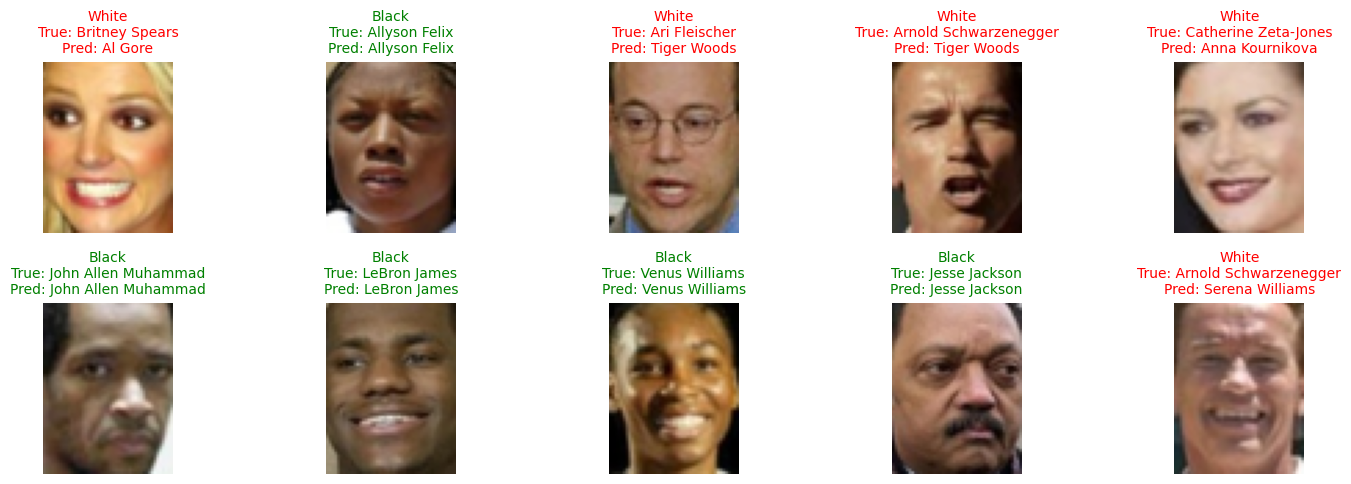

In [26]:
plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, model_predictions_cloaked['SVM (Linear)'], race_mapping, images)

# **Graphs and Visualizations**

# **Effectiveness of Invisibility Cloak Perturbation:**

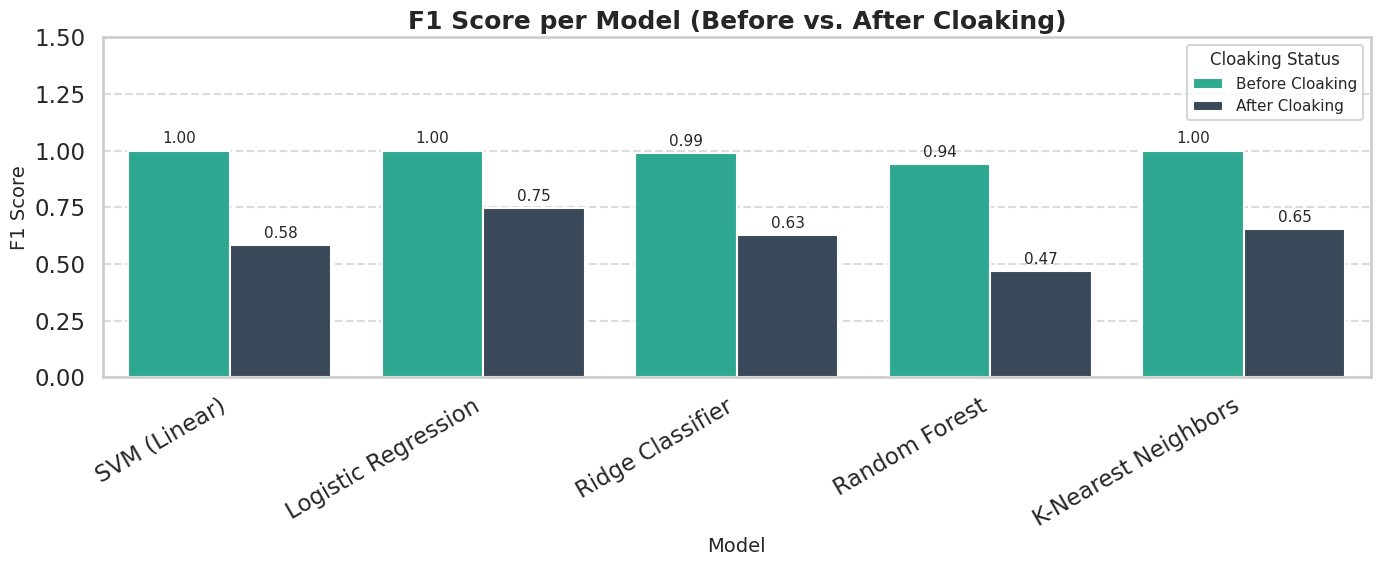

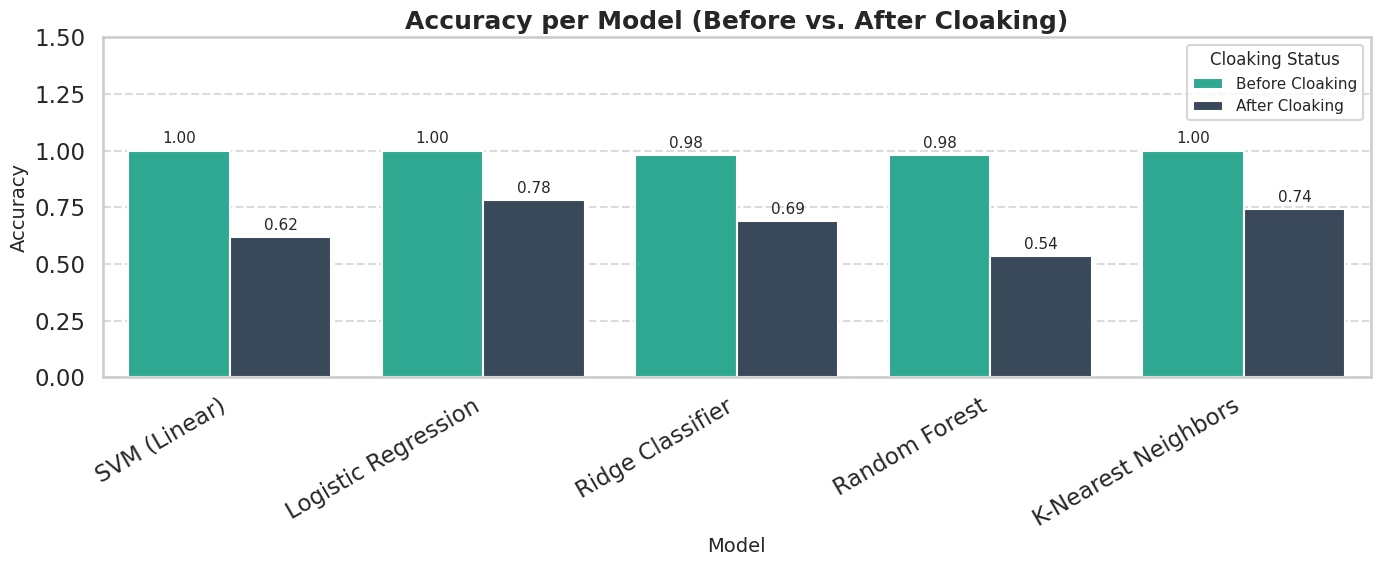

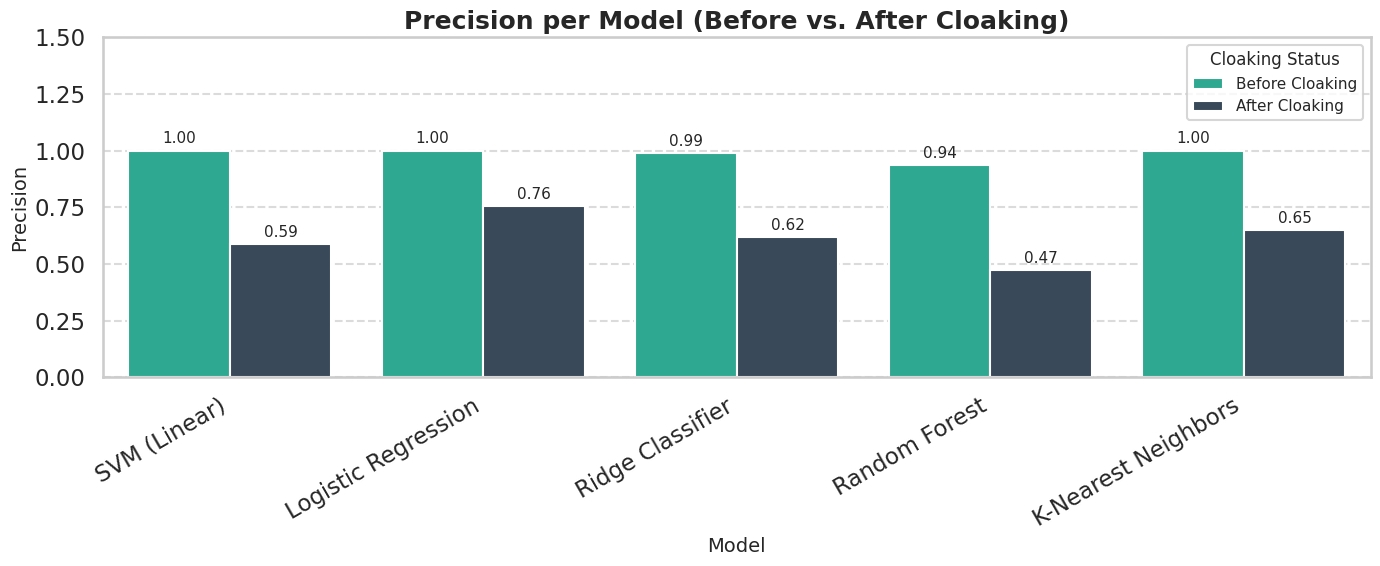

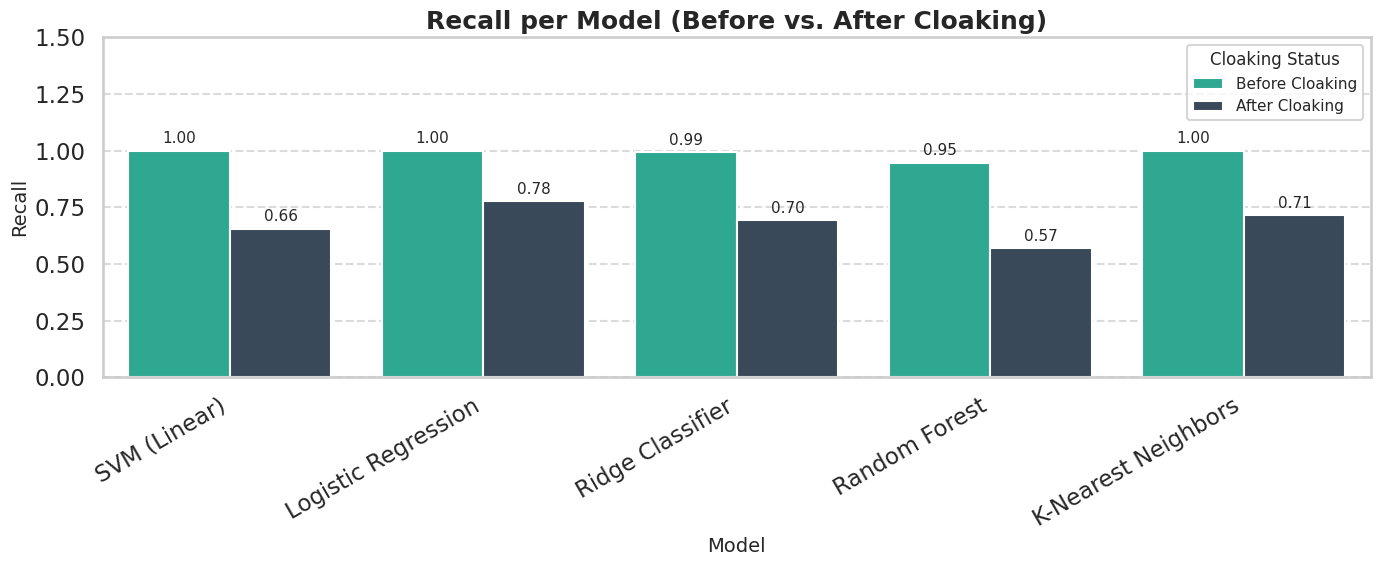

In [17]:
def plot_metric_comparison_by_model(df_before, df_after, metric):
    # Add cloaking status
    df_before = df_before.copy()
    df_before['Cloaked'] = 'Before Cloaking'
    df_after = df_after.copy()
    df_after['Cloaked'] = 'After Cloaking'

    combined_df = pd.concat([df_before, df_after], ignore_index=True)

    # Style
    sns.set(style='whitegrid', context='talk')
    custom_colors = ['#1abc9c', '#34495e']

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(
        data=combined_df,
        x='Model',
        y=metric,
        hue='Cloaked',
        palette=custom_colors
    )

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=11)

    # Aesthetics
    ax.set_title(f"{metric} per Model (Before vs. After Cloaking)", fontsize=18, weight='bold')
    ax.set_xlabel("Model", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    plt.xticks(rotation=30, ha='right')
    ax.legend(title='Cloaking Status', fontsize=11, title_fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.5)

    plt.tight_layout()
    plt.show()

plot_metric_comparison_by_model(df_model_metrics, df_model_metrics_cloaked, 'F1 Score')
plot_metric_comparison_by_model(df_model_metrics, df_model_metrics_cloaked, 'Accuracy')
plot_metric_comparison_by_model(df_model_metrics, df_model_metrics_cloaked, 'Precision')
plot_metric_comparison_by_model(df_model_metrics, df_model_metrics_cloaked, 'Recall')

# **Demographic Disparities in Protection**

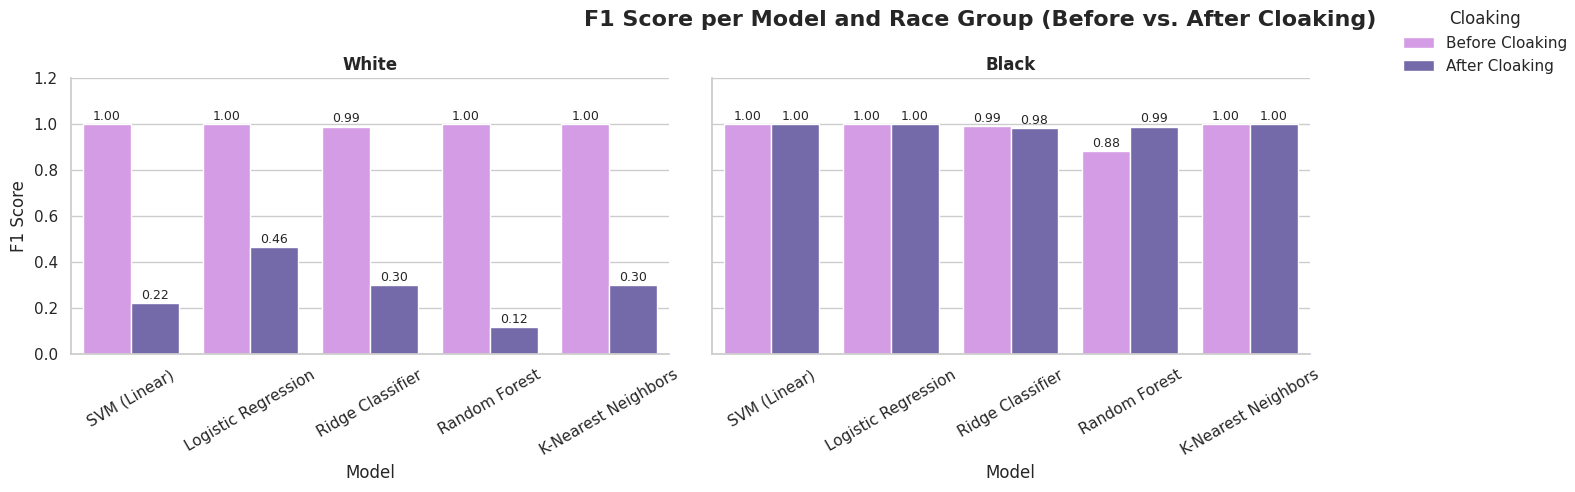

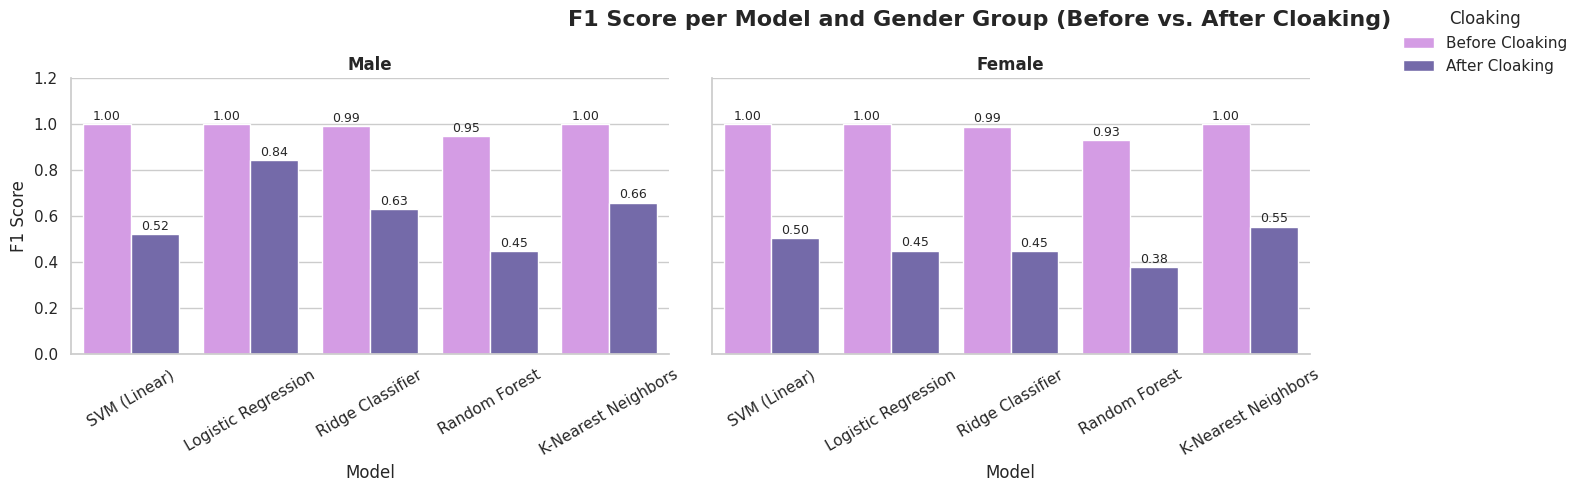

In [18]:
def plot_metric_by_demographic_group(df_before, df_after, metric, demographic_name):
    df_before = df_before.copy()
    df_before['Cloaked'] = 'Before Cloaking'
    df_after = df_after.copy()
    df_after['Cloaked'] = 'After Cloaking'
    combined_df = pd.concat([df_before, df_after], ignore_index=True)

    sns.set(style='whitegrid', context='notebook')

    # Modern color scheme
    palette = ['#db90f0', '#6d5fb3']

    # Calculate number of unique groups for layout
    n_groups = combined_df['Group'].nunique()
    col_wrap = 3
    n_rows = -(-n_groups // col_wrap)  # ceiling division

    # Set up the grid
    g = sns.catplot(
        data=combined_df,
        x='Model',
        y=metric,
        hue='Cloaked',
        col='Group',
        kind='bar',
        height=5,
        aspect=1.2,
        palette=palette,
        col_wrap=col_wrap,
        sharey=True
    )

    g.set_titles(col_template="{col_name}", size=12, weight='semibold')
    g.set_axis_labels("Model", metric)
    g.set(ylim=(0, 1.2))

    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=1, fontsize=9)
        ax.tick_params(axis='x', rotation=30)

    # Adjust layout
    g.fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.4)
    g.fig.suptitle(
        f"{metric} per Model and {demographic_name} Group (Before vs. After Cloaking)",
        fontsize=16, weight='bold'
    )
    g._legend.set_title("Cloaking")
    g._legend.set_bbox_to_anchor((0.8, 0.9))
    g._legend.set_frame_on(False)

    plt.tight_layout()
    plt.show()

plot_metric_by_demographic_group(df_demographic_race, df_demographic_race_cloaked, 'F1 Score', 'Race')
plot_metric_by_demographic_group(df_demographic_gender, df_demographic_gender_cloaked, 'F1 Score', 'Gender')



# Confusion Matrix Analysis:

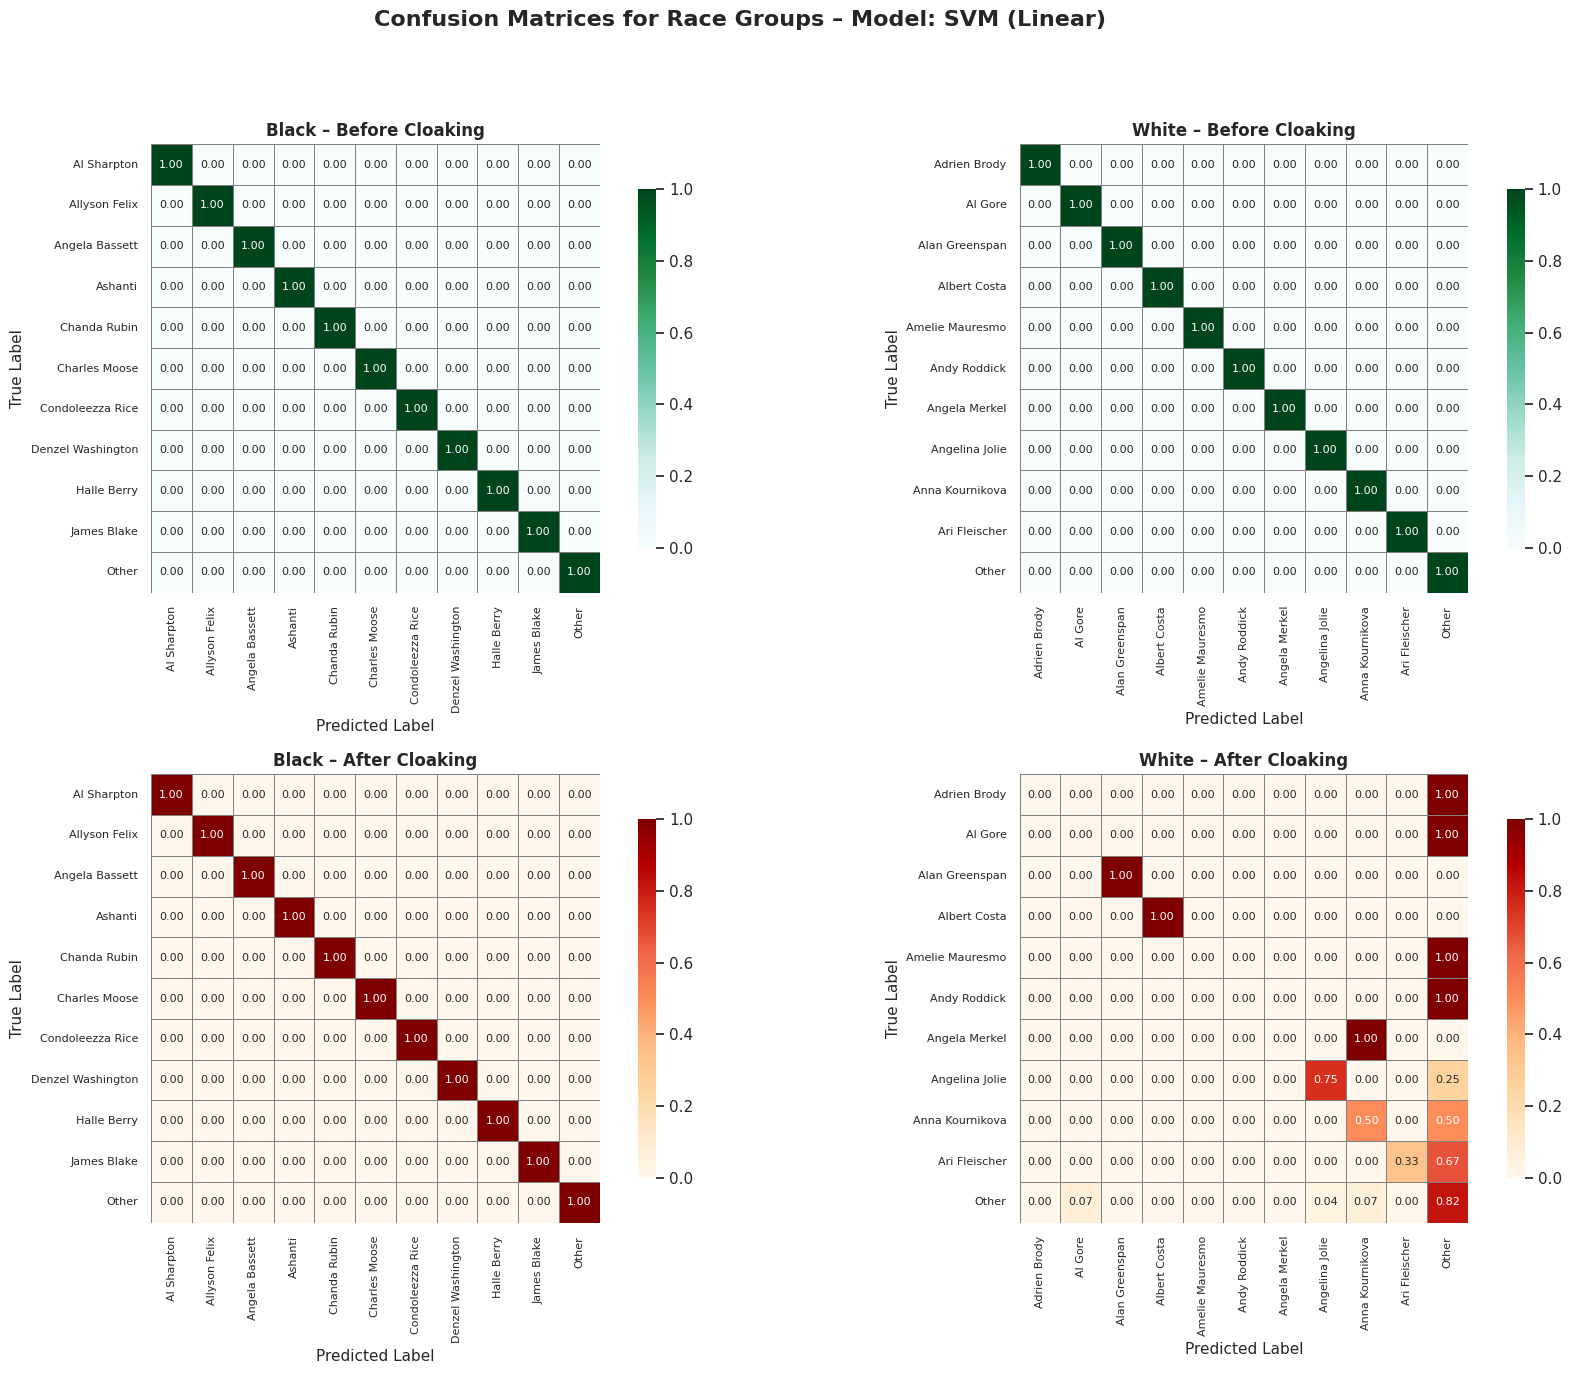

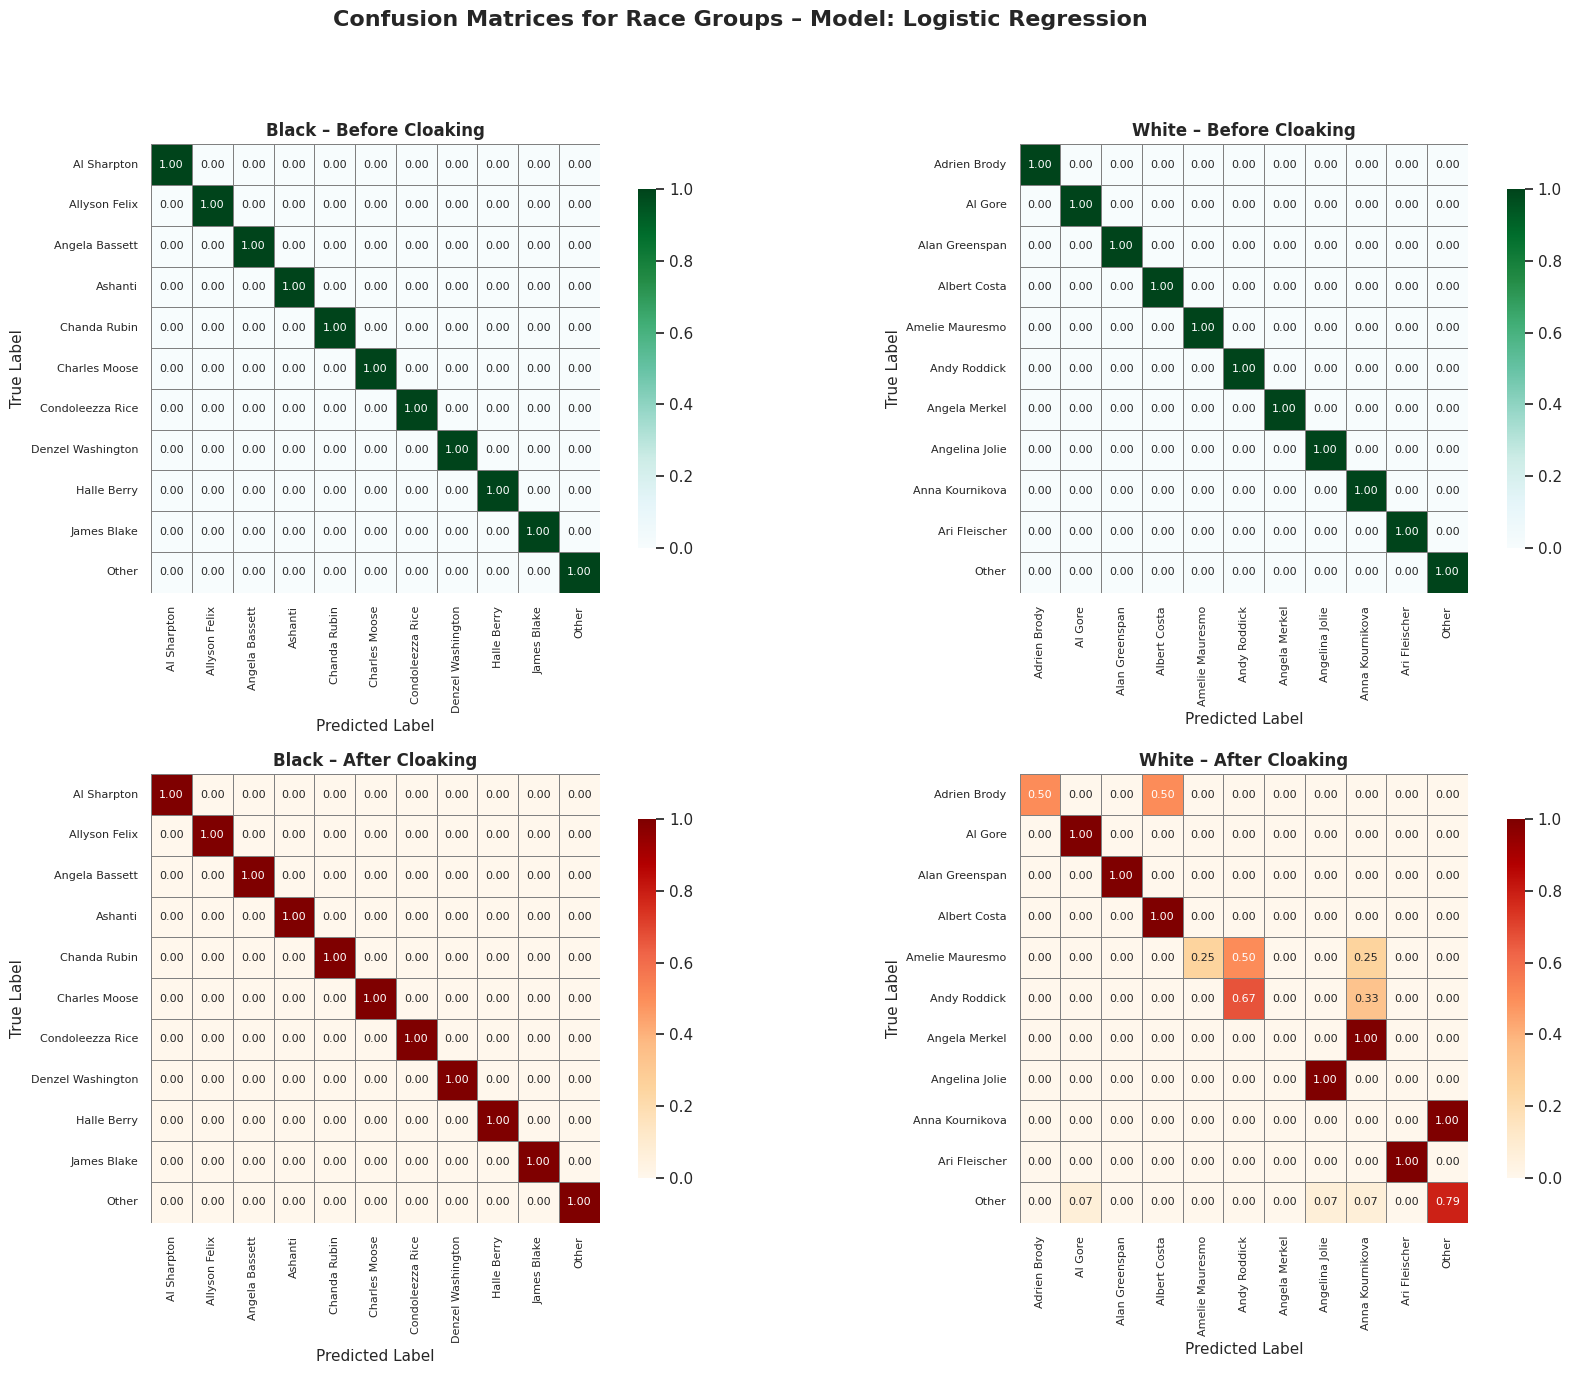

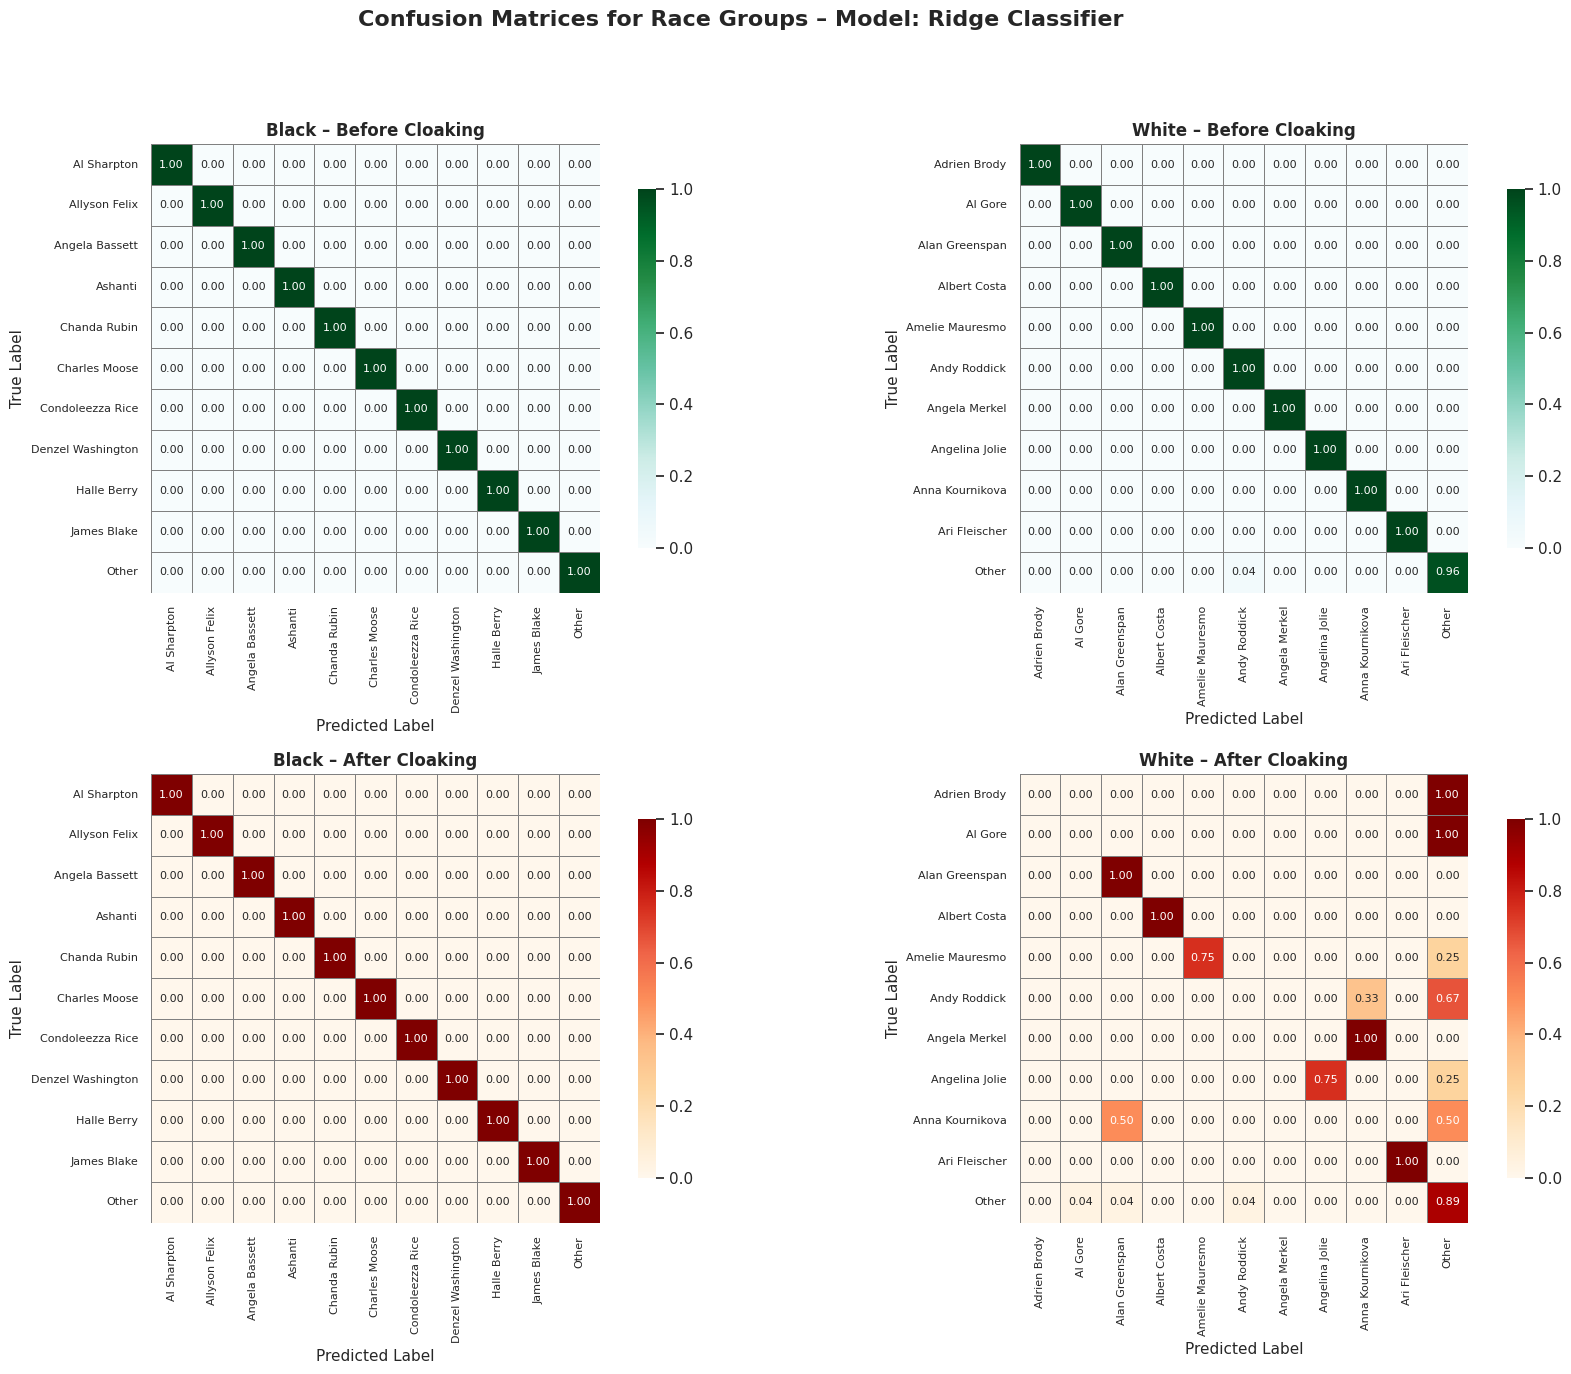

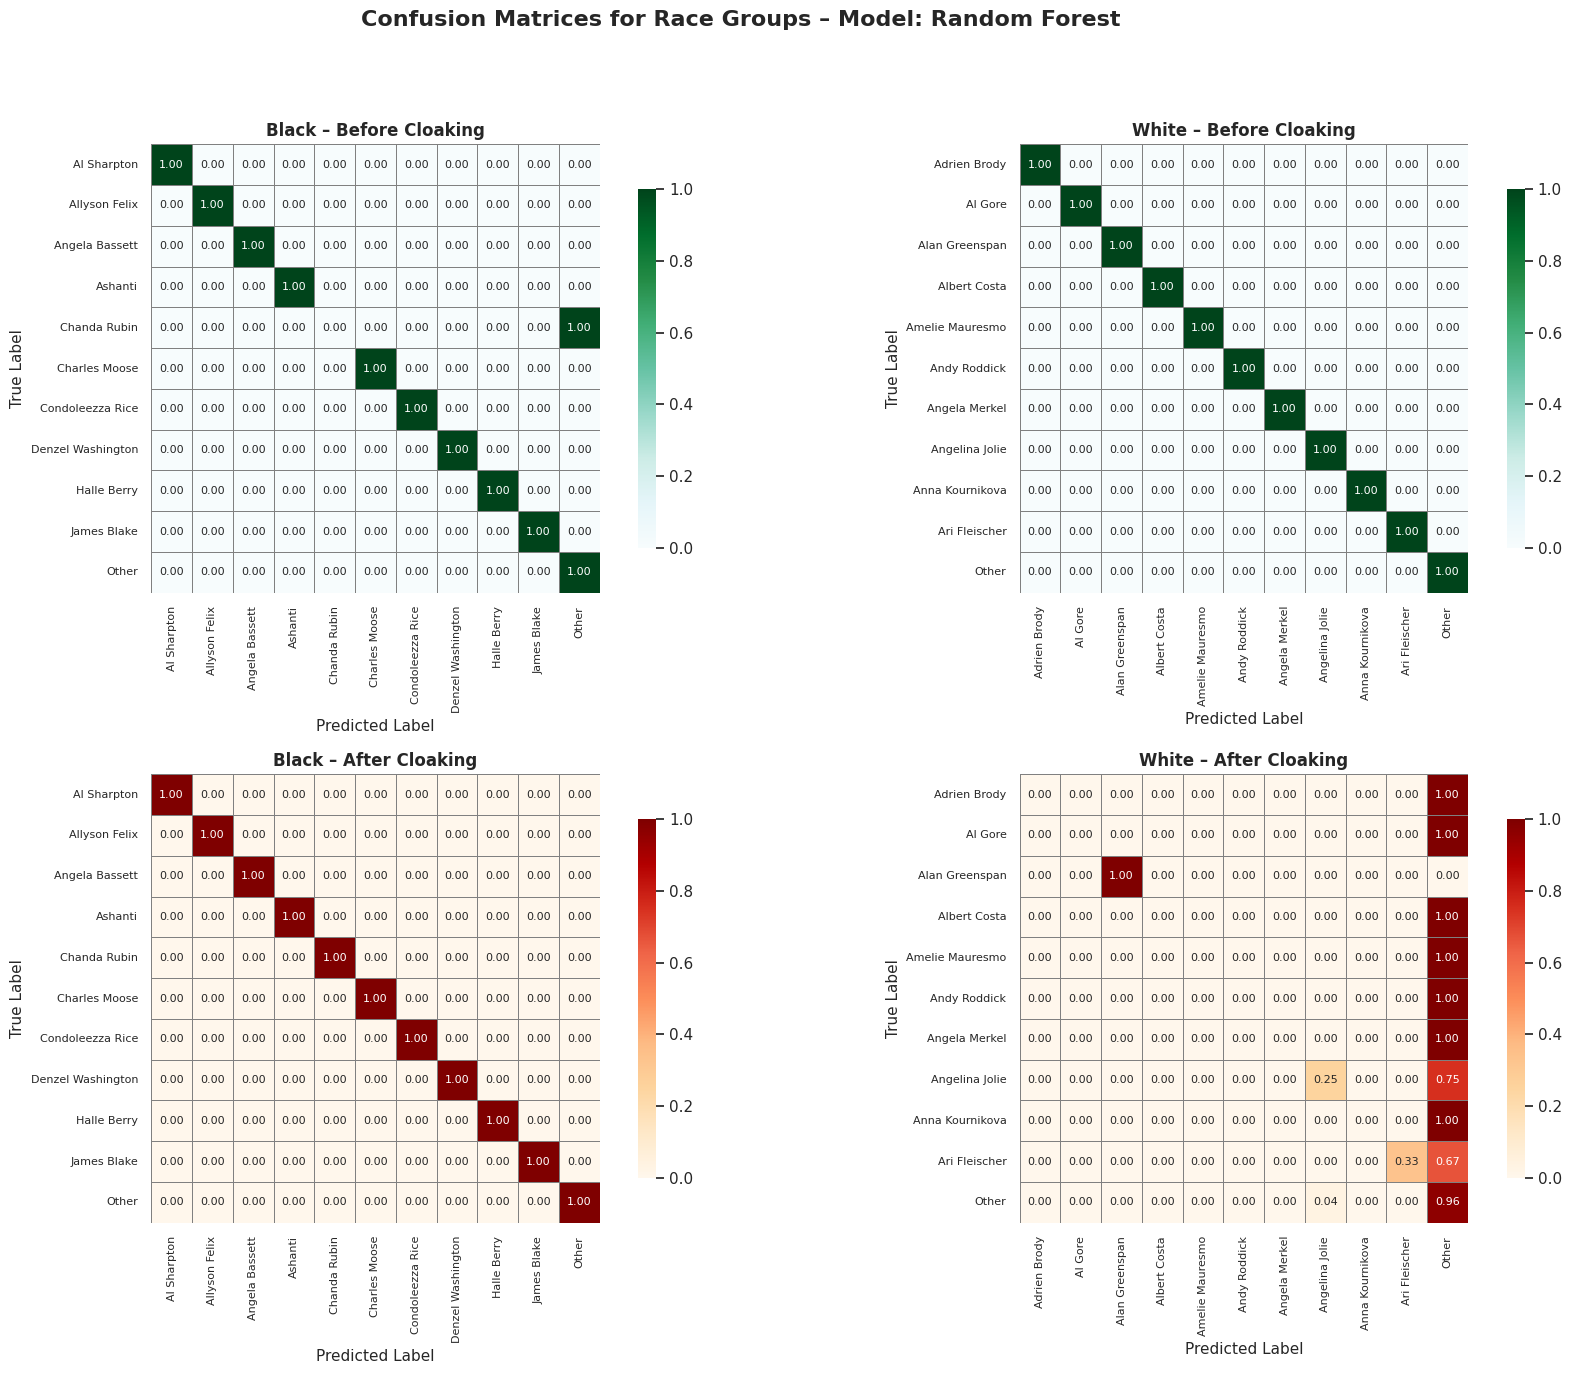

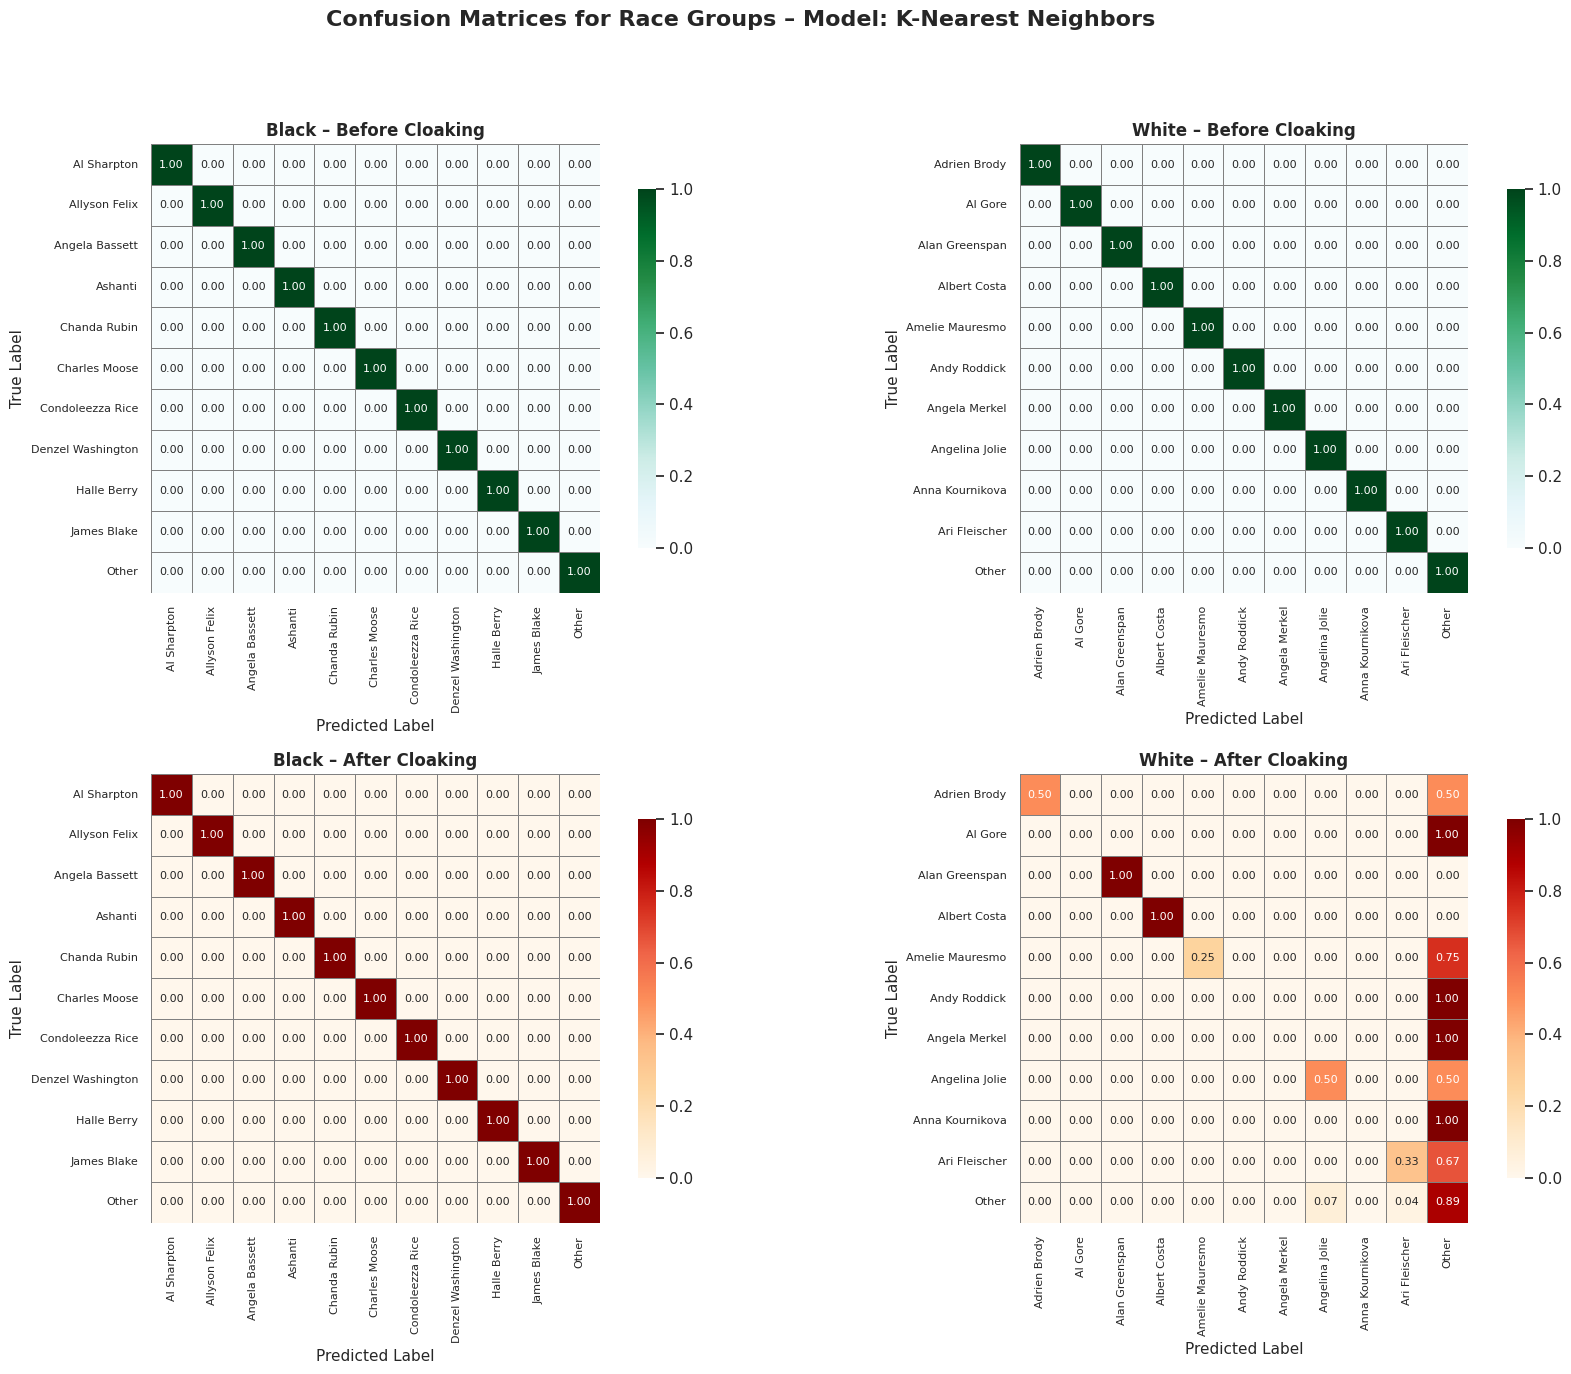

In [39]:
def plot_conf_matrix_by_demographic_pair(y_test, y_pred_before, y_pred_after,
                                         demographic_mapping, label_names, labels,
                                         test_selected_indices, demographic_values,
                                         class_names=None, demog_name="Race",
                                         model="Model", normalize=True, max_labels=15):
    """
    Plot a 2x2 grid of confusion matrices:
    - Columns: demographic groups (e.g., Black, White)
    - Rows: Before and After Cloaking
    """
    assert len(demographic_values) == 2, "Provide exactly two demographic groups."

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))  # rows = stages, cols = demog groups
    stages = ['Before Cloaking', 'After Cloaking']
    cmap_list = ['BuGn', 'OrRd']

    for col_idx, demo_value in enumerate(demographic_values):
        # Filter samples for current demographic group
        name_list = [label_names[labels[idx]] for idx in test_selected_indices]
        group_indices = [i for i, name in enumerate(name_list) if demographic_mapping.get(name) == demo_value]

        y_true = np.array(y_test)[group_indices]
        y_pred_b = np.array(y_pred_before)[group_indices]
        y_pred_a = np.array(y_pred_after)[group_indices]

        labels_present = np.unique(y_true)
        if class_names is not None:
            class_names_filtered = [class_names[i] for i in labels_present]
        else:
            class_names_filtered = labels_present

        # Optionally truncate
        if len(labels_present) > max_labels:
            labels_present = labels_present[:max_labels]
            y_true = np.array([y if y in labels_present else -1 for y in y_true])
            y_pred_b = np.array([y if y in labels_present else -1 for y in y_pred_b])
            y_pred_a = np.array([y if y in labels_present else -1 for y in y_pred_a])
            class_names_filtered = [str(c) for c in class_names_filtered[:max_labels]] + ['Other']
            labels_present = np.append(labels_present, -1)

        # Compute confusion matrices
        cm_before = confusion_matrix(y_true, y_pred_b, labels=labels_present,
                                     normalize='true' if normalize else None)
        cm_after = confusion_matrix(y_true, y_pred_a, labels=labels_present,
                                    normalize='true' if normalize else None)

        # Row 0 = Before, Row 1 = After
        for row_idx, (cm, stage_title, cmap) in enumerate(zip([cm_before, cm_after], stages, cmap_list)):
            ax = axes[row_idx, col_idx]
            sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                        xticklabels=class_names_filtered, yticklabels=class_names_filtered,
                        cbar=True, linewidths=0.5, linecolor='gray',
                        ax=ax, square=True, annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
            ax.set_title(f"{demo_value} – {stage_title}", fontsize=12, weight='bold')
            ax.set_xlabel("Predicted Label", fontsize=11)
            ax.set_ylabel("True Label", fontsize=11)
            ax.tick_params(axis='x', labelrotation=90, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

    plt.suptitle(f"Confusion Matrices for {demog_name} Groups – Model: {model}", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


for name in models:
  plot_conf_matrix_by_demographic_pair(
      y_test=y_test,
      y_pred_before=model_predictions[name],
      y_pred_after=model_predictions_cloaked[name],
      demographic_mapping=race_mapping,
      label_names=label_names,
      labels=labels,
      test_selected_indices=test_selected_indices,
      demographic_values=["Black", "White"],
      class_names=le.classes_,
      demog_name="Race",
      model=name,
      normalize=True,
      max_labels=10
  )
